# guppyBasecallerSlowdown.ipynb
## Marcus Viscardi,    September 19, 2023

I am trying to figure out why we have seen SUCH a slowdown with my recent 5TERA libraries during basecalling (and potentially nanopolish polyA?)

In [93]:
from pathlib import Path
import re
from pprint import pprint
import pandas as pd

In [94]:
# I only want to use the newest *guppy*.log file for each run, so I will use a dictionary to store the results
working_dir = Path("/data16/marcus/working")
results_dict = {}
version_and_samples_per_second = []
for log_dir in working_dir.glob("*anoporeRun*/output_dir/logs"):
    run_name = log_dir.parent.parent.stem[19:]
    guppy_logs = [file for file in log_dir.glob("*guppy*.log")]
    newest_guppy_log = sorted(guppy_logs, key=lambda x: x.stat().st_mtime)[-1]
    run_date = newest_guppy_log.stem[:6]
    with newest_guppy_log.open('r') as f:
        file_lines = f.read()
    
    try:
        guppy_version = re.search(r'version \d+\.\d+\.\d+\+.+?[,\n]', file_lines).group()[8:-1]
    except AttributeError:
        guppy_version = "Unknown"
        print(f"Failed for {newest_guppy_log}")
    try:
        samples_per_second = re.search(r'samples/s: .+?[\n]', file_lines).group()[11:-1]
    except AttributeError:
        samples_per_second = "0.0"
        print(f"Failed for {newest_guppy_log}")
    
    results_dict[run_name] = {'run_date': run_date,
                              'run_name': run_name,
                              'guppy_version': guppy_version,
                              'samples_per_second': float(samples_per_second)}
    version_and_samples_per_second.append((guppy_version, float(samples_per_second)))
    # print(f"Run Date: {run_date:>6} | Run Name: {run_name:>45} | Guppy Version: {guppy_version:>16} | Samples/Sec: {samples_per_second:>12}")
# Let's convert the results_dict into a pandas dataframe:
results_df = pd.DataFrame.from_dict(results_dict, orient='index').reset_index(drop=True)
results_df = results_df.sort_values(by=['run_date', 'run_name'])
results_df = results_df.query('guppy_version != "Unknown"').query('samples_per_second != 0.0')
results_df

,run_date,run_name,guppy_version,samples_per_second
27,211031,0639_L3s,5.0.16+b9fcd7b5b,16033400.0
29,211101,polyA_0639_L3_replicate,5.0.16+b9fcd7b5b,16176800.0
14,211101,totalRNA_0639_L3_replicate,5.0.16+b9fcd7b5b,16542000.0
26,211101,totalRNA_5108_xrn-1-KD,5.0.16+b9fcd7b5b,16740500.0
9,211103,riboD-and-yeastCarrier_0639_L3,5.0.16+b9fcd7b5b,15021800.0
21,211103,totalRNA_0639_L3,5.0.16+b9fcd7b5b,26664500.0
11,211121,pTRIstds,5.0.16+b9fcd7b5b,36665400.0
10,211212,pTRIstds_TERA3,6.0.0+ab7925058,35626500.0
35,220131,polyA_0639_L3_third,6.0.1+652ffd179,20213300.0
23,220131,totalRNA_0639_L3_third,6.0.1+652ffd179,20221900.0


Done.


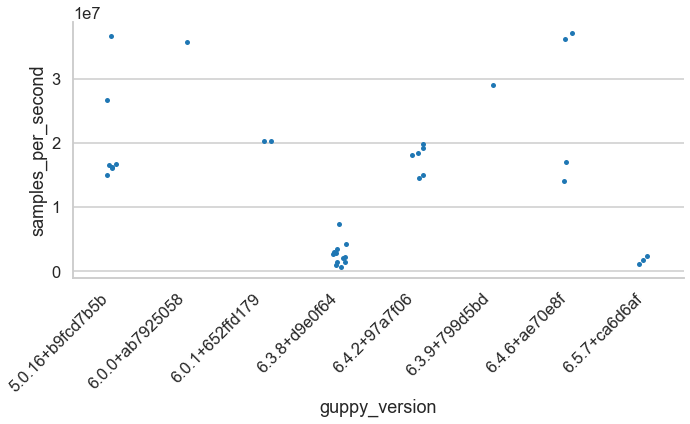

In [96]:
import seaborn as sea

sea.set_style('whitegrid')
sea.set_context('talk')
fig = sea.catplot(x='guppy_version', y='samples_per_second', data=results_df, kind='strip', aspect=2)
fig.set_xticklabels(fig.axes[0][0].get_xticklabels(), rotation=45, horizontalalignment='right')
print(f"Done.")

# In Conclusion:

It looks like the slowdown is fairly substantial, but not as bad as I thought it was. I will need to look into this more, but I think it is safe to say that the slowdown is related to the version number